# Stock Price Prediction

#### PROBLEM STATEMENT
<ul>
<li>To predict stock price change for Apple Inc. using time series analysis on historical data between 2000 - 2016 based on closing prices of stock for the year 2017.<br>
<li>To analyze the impact of market news on the stock prices by checking for correlation between news sentiments and stock price change


In [1]:
import pandas as pd
import numpy as np
from pandas import Series
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats 
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

#### Pre-processing Time series data

From the initial stock price data, we have chosen closing price(Close) to represent the price of the index to be predicted. Since, it reflects all the activities of the index in a trading day. 

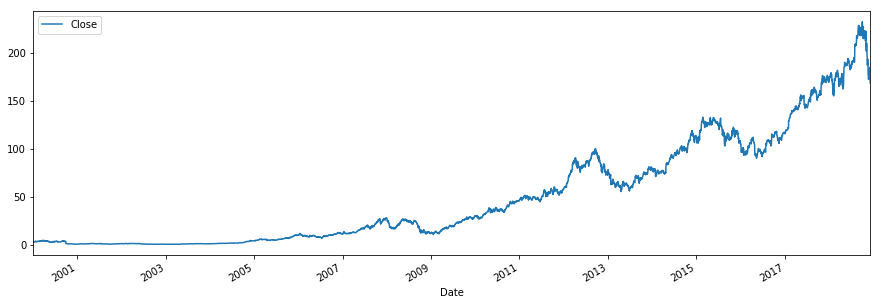

In [2]:
# to load time series data
def load_csv(name):
    time_series = pd.read_csv(name)
    # we require the closing price and the date for furthur analysis
    time_series = time_series[["Date","Close"]]
    #Converting the varibles to date time format using to_datetime
    time_series.Date = pd.to_datetime(time_series.Date, format ="%Y-%m-%d")
    # Setting date as index
    time_series.set_index('Date',inplace=True) 
    return time_series

def plotTimeseries(data):
    return data.plot(figsize = (15,5))

name = "AAPL_FINAL.csv"
time_series = load_csv(name)
plotTimeseries(time_series)

#test_data = time_series.copy()

This is our time series for Apple stock prices from 2000 - 2018

In [3]:
def summary_statistics(df):
    
    # Checking if histogram fits a Gaussian Curve
    df.hist(figsize=(5, 5))
    plt.show()
    
    # We then split data into two and calculate means and variances and see if they vary significantly
    total_values= len(df)
    val1, val2 = df[0:int(total_values/2)], df[int(total_values/2):]
    
    mean1 = val1.mean()
    mean2 = val2.mean()
    var1 = val1.var()
    var2 = val2.var()
    
    print('mean of 1st part:',mean1,'and mean of 2nd part:',mean2)
    print('variance of 1st part:',var1, 'variance of 2nd part:',var2)
    
    # We consider that the time series might be stationary if corresponding means and variances differ slightly
    if (abs(mean1-mean2) <= 8 and abs(var1-var2) <= 10):
        print("Time Series may be stationary, since means and variances of the parts do not vary signifincantly.\n")
    else:
        print("Time Series may not be stationary, since means and variances of the parts vary significantly.\n")

In [4]:
def adf_test(df):
    # Augmented Dickey-Fuller statistic test 
    print("Performing Augmented Dickey-Fuller Test to check for stationarity")
    
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
    p = result[1]
    if (p > 0.05):
        print("p-value > 0.05, Time Series NOT Stationary")
        return 1
    else:
        print("p-value <= 0.05, Time Series is Stationary")
        return 0
    
    

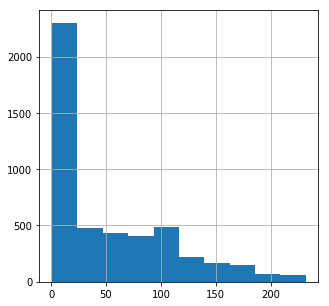

mean of 1st part: 7.6947895004198115 and mean of 2nd part: 94.93597455541574
variance of 1st part: 56.486081969230824 variance of 2nd part: 2340.1380542374677
Time Series may not be stationary, since means and variances of the parts vary significantly.

Performing Augmented Dickey-Fuller Test to check for stationarity
ADF Statistic: 0.26277170951
p-value: 0.975570502743
p-value > 0.05, Time Series NOT Stationary


In [5]:
# to check if a time series is stationary
def is_stationary(df):
     
    summary_statistics(df)
    diff = adf_test(df)
    
    return(diff)

differencing = is_stationary(time_series.Close)

The ACF and PACF Plots for the AAPL Stock's Data are as follows: 



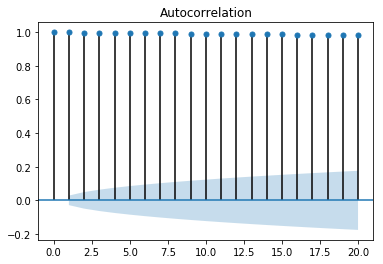

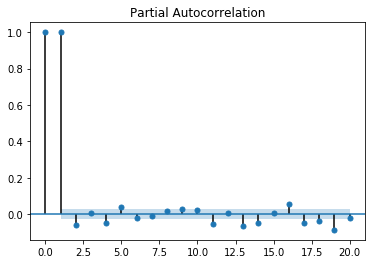

In [6]:
def plotAcfPacf(closingValues, numberOfLags):
    print("The ACF and PACF Plots for the AAPL Stock's Data are as follows: \n")
    plot_acf(closingValues, lags = numberOfLags)
    plot_pacf(closingValues, lags = numberOfLags)
     
plotAcfPacf(time_series['Close'], 20)

Looking at all the test results and ACF and PACF plots, we know that differencing needs to be applied. Here below we have performed grid search using AIC and BIC values to find optimal p, d, q parameter values for ARIMA model. <br>
We used AIC and BIC to determine the hyperparametrs, as when fitting models, it is possible to increase the likelihood by adding parameters, however, that may result in overfitting of the model. 
Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model.

In [7]:
def getArimaParameters(dataset, p, q, d):
    
    p_range = p
    q_range = q
    d_range = d

    # list to store the aic , bic and pdq values
    aic_values = []
    bic_values = []
    pdq_values = []
  
    # checking for all combinations of pdq to find the optimal set of parameters 
    for p in p_range:
        for q in q_range:
            for d in d_range:
                try:
                    model = ARIMA(dataset, order=(p, d, q))
                    results = model.fit(disp= -1)
                    # calculating aic and bic values for each configuration and appending thier 
                    #values to respective lists
                    aic_values.append(ARMAResults.aic(results))
                    bic_values.append(ARMAResults.bic(results))
                    pdq_values.append((p, d, q))
                   
                except Exception as e:
                    pass
    
    # checking for the lowest values, to find the optimal parameters
    best_pdq = pdq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
    print("(p,d,q) corresponding to lowest AIC score: ", best_pdq)
  
    return best_pdq, pdq_values


p_value = [0,1,2]
q_value = [0,1,2]
d_value = [1]

best_pdqValue, pdq = getArimaParameters(time_series["2000-01-03":"2016-01-03"], p_value, q_value, d_value)


(p,d,q) corresponding to lowest AIC score:  (2, 1, 0)


In [8]:
def run_arima(start_train, end_train, step, best_pdqValue):
    
    #building arima model with the parameters from above and fitting it to train data
    arima_model = ARIMA(time_series[start_train: end_train], order=best_pdqValue).fit()
    #predicting the results using forecast, specifying number of steps
    res = pd.DataFrame(arima_model.forecast(steps=step)[0], columns = ['Close'])
    return res

In [9]:
#defining start date and end date for train and test dataset
start_train = "2000-01-01"
end_train = "2016-01-01"
start_test = "2016-01-01"
end_test = "2017-01-01"

# defining test dataset
test_data = time_series[start_test: end_test]

res = run_arima(start_train,end_train, 252, best_pdqValue)
test_data['Predicted Close'] = res.values

#### Evaluation of ARIMA Model
We evaluated the ARIMA model using Mean Absolute Error and Mean Forecast Error, this provides us with forecast bias.

In [10]:
def MFE_MAE(actual, predicted):
    #calculating the difference
    f_err = (actual-predicted)
    #calculating the mean
    mean_f_err = np.mean(f_err)
    
    #calculating mean absolute error 
    mean_a_err= mean_absolute_error(actual, predicted)
    
    return(mean_f_err, mean_a_err) 


#### Prediction for year 2017

Mean Forecast Error: -3.94420467439
Mean Absolute Error: 6.092412255


,Close,Predicted Close
Date,,
2016-01-04,105.349998,105.321913
2016-01-05,102.709999,105.415030
2016-01-06,100.699997,105.439362
2016-01-07,96.449997,105.462343
2016-01-08,96.959999,105.487552


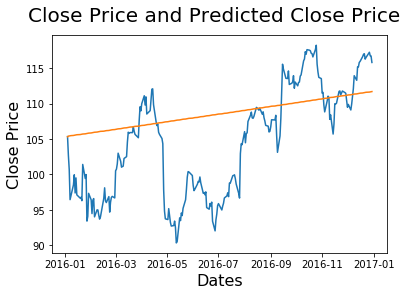

In [11]:
mfe,mae = MFE_MAE(test_data[start_test:end_test].Close.values, res.Close.values)
print("Mean Forecast Error:", mfe)
print("Mean Absolute Error:",  mae)

fig = plt.figure()
plt.plot(test_data)
fig.suptitle('Close Price and Predicted Close Price', fontsize=20)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Close Price', fontsize=16)

test_data.head()

<ul>
<li>To visualize the results, we have plotted the actual closing price of the stock and the predicted closing price by our model. We can note here that most of the predicted observations are overshooting the actual observations.
This is evident from our evaluation metrics. Since, our MFE is neagtive, we can conclude that our model is overforecasting.

#### Prediction for the year 2008 (During the recession)

<ul>
<li>We thought it would be interesting to see and analyse the trends and prediction for different periods of time and for special years like recession to see how our model performs

Mean Forecast Error: -9.42282803526
Mean Absolute Error: 9.42282803526


,Close,Predicted Close
Date,,
2008-09-02,23.741428,24.234795
2008-09-03,23.851429,24.238479
2008-09-04,23.031429,24.247907
2008-09-05,22.882856,24.257145
2008-09-08,22.559999,24.266437


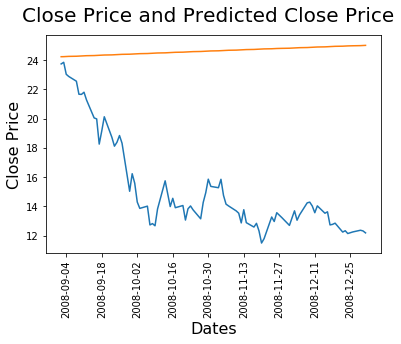

In [12]:
test_data_recession = time_series["2008-09-01": "2009-01-01"]
res_recession = run_arima("2000-01-01","2008-08-31", 85, best_pdqValue)

test_data_recession['Predicted Close'] = res_recession.values

fig = plt.figure()
plt.plot(test_data_recession)
fig.suptitle('Close Price and Predicted Close Price', fontsize=20)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.xticks(rotation = 90)

mfe1,mae1 = MFE_MAE(test_data_recession["2008-09-01": "2009-01-01"].Close.values, res_recession.Close.values)
print("Mean Forecast Error:", mfe1)
print("Mean Absolute Error:",  mae1)
test_data_recession.head()

<ul>
<li>Analyzing the above results, we didn’t get very accurate results for the recession period in 2008. This might be beacuse the arima model was trained on historic increasing trend data. So, it failed to catch the falling trend when stock market crashed.
<li> Thus, makes it evident that other factors also play an important role in prediction of stock price change. 

## Performing sentiment analysis on news data

#### Pre-processing News Data

<ul>
<li>For cleaning data, we used the news type attribute to filter news in finance, business and technology ensuring we have gathered information pertaining to Apple Inc. 
<li>Filtered news with regular expression having “Apple”
<li>Removed duplicate news.
<li>We considered news summary for analyzing the news sentiment, since Title column of the news data gave us very vague idea about the sentiments.
<br>Eg: "Apple stock valuation buy, sell or hold"
     <br>"Warren Buffett's top 5 holdings"



In [13]:
def read_newsData(source_name):
    # reading intrinio news data
    intrinio_data = pd.read_csv(source_name)
    #cleaning the data only keeping the fields of apple
    intrinio_data = intrinio_data[intrinio_data.summary.str.contains("Apple") == True]
    #to remove the columns which are null
    null_columns = intrinio_data.columns[intrinio_data.isnull().any()]
    intrinio_data[null_columns].isnull().sum()
    intrinio_data = intrinio_data.dropna()
    #extracting the important columns
    intrinio_data = intrinio_data[["publication_date","summary"]]
    
    #intrinio_data.to_csv("cleanedIntrinioData.csv", encoding="utf-8")
    # converting publication date into dateTime foramt
    intrinio_data['publication_date'] = pd.to_datetime(intrinio_data['publication_date'],infer_datetime_format=True)
    intrinio_data['publication_date'] = intrinio_data['publication_date'].dt.date
    
    return(intrinio_data)
    
news_source = "NewIntrinioData.csv"
intrinio_data = read_newsData(news_source)
#intrinio consists of the news data
intrinio_data.head()

,publication_date,summary
3,2018-12-07,Cannabis company MedMen Enterprises Inc. has h...
8,2018-12-07,Apple has purchased a tech startup called Plat...
10,2018-12-07,"Two of the biggest tech companies, Apple and G..."
11,2018-12-07,U.S. stocks finished sharply lower on Friday a...
12,2018-12-07,Apple&apos;s older iPhones are seeing some love.


In [14]:
# perform sentiment analysis on the news data
def sentiment_analysis(news_df):
    #initialising sentiment intensity anlayzer model
    analyser = SentimentIntensityAnalyzer()
    # list to store the score for the news_df
    score = []
    for index, row in news_df.iterrows():
        # appeding the compound score that is returned from the analyzer
        score.append(analyser.polarity_scores(row["summary"])["compound"])

    news_df["sentiment_score"] = score
    
sentiment_analysis(intrinio_data)
intrinio_data.head()

,publication_date,summary,sentiment_score
3,2018-12-07,Cannabis company MedMen Enterprises Inc. has h...,0.4767
8,2018-12-07,Apple has purchased a tech startup called Plat...,0.6369
10,2018-12-07,"Two of the biggest tech companies, Apple and G...",0.0000
11,2018-12-07,U.S. stocks finished sharply lower on Friday a...,-0.1280
12,2018-12-07,Apple&apos;s older iPhones are seeing some love.,0.6369


### Evaluation of the sentiment analyser model

In [15]:
new_validation = intrinio_data.copy()
# validation df to first 100 values to be comapared with the manually made ground truth
validation = new_validation.head(100)

for index, row in intrinio_data.head(100).iterrows():
    if(row['sentiment_score']> 0.5):
        validation.loc[index,'sentiment_score'] = 1
    elif (row['sentiment_score']<-0.2):
        validation.loc[index,'sentiment_score'] = -1
    else:
        validation.loc[index,'sentiment_score'] = 0
        
validation.head()


,publication_date,summary,sentiment_score
3,2018-12-07,Cannabis company MedMen Enterprises Inc. has h...,0.0
8,2018-12-07,Apple has purchased a tech startup called Plat...,1.0
10,2018-12-07,"Two of the biggest tech companies, Apple and G...",0.0
11,2018-12-07,U.S. stocks finished sharply lower on Friday a...,0.0
12,2018-12-07,Apple&apos;s older iPhones are seeing some love.,1.0


Since the model gives a numeric result between -1 and 1, we updated scores given by sentiment analyzer model for same dates to form a multiclass feature with values {positive = +1, negative = -1, rest=0}
After, checking with various values by setting a threshold of +1 for sentiment scores > 0.5, -1 for sentiment scores < -0.2 and rest as neutral scores we got the best accuracy.

In [16]:
# reading the labeled data 
labeled_data = pd.read_csv("labeled.csv")

# reseting the index of the validation set
validation = validation.reset_index(drop = True)
# reseting the index of the labeled_data set
labeled_data = labeled_data.reset_index(drop = True)
validation.index = labeled_data.index
# adding the Label column from labeled_data to validation
validation["Label"] = labeled_data["Label"]


#### Calculating accuracy 

In [17]:
# dummy variable to store the number of correctly predicted values
count = 0 

# Looping across all the rows, to check actual and predicted values.
for index, row in validation.iterrows():
    if (row["sentiment_score"] == row["Label"]):
        count+=1
    #print(count)

accuracy = (count/100)*100
print("The accuracy of the sentiment analysis model is",accuracy,"%")

The accuracy of the sentiment analysis model is 68.0 %


<ul>
<li>From the results, we can see that the sentiment analyzer model is not very accurate. This is because the model does not perform a subjective rule based sentiment analysis in context to a specific noun/subject. 
For eg: If our subject is Apple, and a news has more positive details about Microsoft and little negative details about Apple, it should result in negative score for Apple. But the model takes into consideration the overall sentiment of the article and gives it a positive score whereas it should be given negative score in context to Apple.


## Analysing impact of market news sentiments on stock price

In [18]:
def group_day(news_df,n):
    # A temporary dataframe to store the group by values according to date
    temp = news_df.groupby('publication_date')['sentiment_score'].apply(list)
    
    # going across all the rows of the temp(grouped) dataframe and storing the average of the top 5
    for i in range(0,len(temp)):
        res =[]
        for j in range(0,n):
            try:
                #finding the index of max value element
                pos = max(temp[i])
                #as abs magnitudes are to be considered, the most negative value can also have the max magnitude
                neg = abs(min(temp[i]))
                # storing which ever is greater
                if(pos>neg):
                    index = temp[i].index(pos)
                else:
                    index = temp[i].index(-1*(neg))
                
                res.append(temp[i][index])
                del temp[i][index]
            except ValueError:
                pass
        #taking the mean of the top 5
        temp[i] = np.mean(res)
        #print(temp[i])
    
    return(temp)

scored_data = group_day(intrinio_data, 5)

<ul>
<li>As we had multiple news articles for the same date, we took into consideration the top 5 news of the day on the basis of absolute maximum magnitude of sentiment scores, and assigned their average value. If we take too many articles having varied scores, there is a chance their average value will underestimate the important news. And, if we take too less articles, it would lead to a bias result.

In [19]:
# making the datetime formats same for both the dataframes to combine
res_df = pd.DataFrame(scored_data).reset_index()
res_df['publication_date'] = pd.to_datetime(res_df['publication_date'], format = '%Y-%m-%d',errors = 'coerce')
res_df['publication_date'] = res_df['publication_date'].dt.date

# Using stock_price dataframe to find correaltion between news sentiments and stock price data
stock_price = time_series.copy()
stock_price = pd.DataFrame(stock_price).reset_index()
# Renaming the Date column in stock_price df to Publication_date
stock_price.rename(columns = {"Date":'publication_date'},inplace=True)
# converting the publication_date into datetime foramt
stock_price['publication_date'] = pd.to_datetime(stock_price['publication_date'], format = '%Y-%m-%d',errors = 'coerce')
stock_price['publication_date'] = stock_price['publication_date'].dt.date

In [20]:
# merging the results of the sentiment score with stock price data on publication_date
merged_score_news = pd.merge(res_df, stock_price, on = ['publication_date'], how = 'inner')
merged_score_news.head()

,publication_date,sentiment_score,Close
0,2016-05-24,0.1679,97.900002
1,2016-05-25,0,99.620003
2,2016-06-01,0,98.459999
3,2016-06-20,0,95.099998
4,2016-06-22,-0.3818,95.550003


In [21]:
# Checking for correlation with Pearson's correlation coefficient
merged_score_news.sentiment_score = merged_score_news.sentiment_score.astype(float)
print("Pearsons's Correlation Results")
print(merged_score_news.corr(method='pearson'))

Pearsons's Correlation Results
                 sentiment_score     Close
sentiment_score         1.000000  0.271389
Close                   0.271389  1.000000


<ul>
<li>Looking at results, we see that Closing Price(Close) and sentiment score have a positive correlation which means as the sentiment becomes more positive, we can expect rise in the stock price.

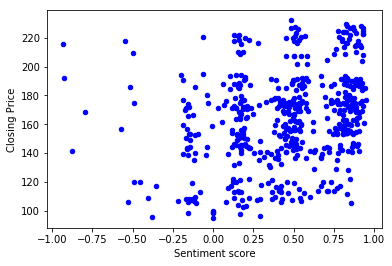

In [22]:
#Plotting the correlation 
ax2 = merged_score_news.plot.scatter(x='sentiment_score',y='Close',c='blue')
ax2.set_ylabel('Closing Price')
ax2.set_xlabel('Sentiment score')
plt.show()

Sentiment score and close price change


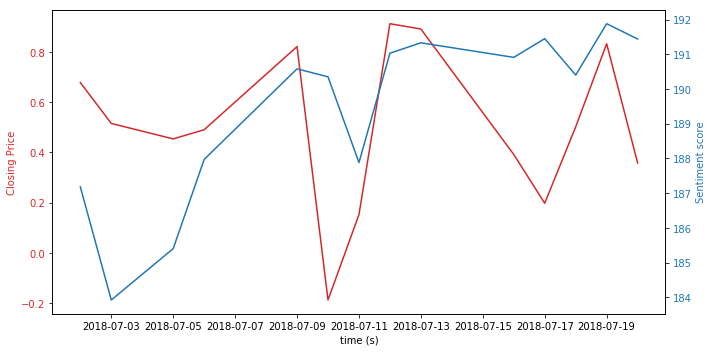

In [23]:
def plot_sentiment_vs_closePrice(merged, start_date,end_date):
    #Plotting the closing price of the stock 
    mask = (merged['publication_date'] > start_date) & (merged['publication_date'] <= end_date)
    t = merged.loc[mask]['publication_date']
    data1 = merged.loc[mask]['sentiment_score']
    data2 = merged.loc[mask]['Close']
    fig, ax1 = plt.subplots(figsize=(10,5))

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Closing Price', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    # Plotting the sentiment score
    color = 'tab:blue'
    ax2.set_ylabel('Sentiment score', color=color)
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    
start_date = "2018-07-01"
end_date = "2018-07-20"

print("Sentiment score and close price change")
plot_sentiment_vs_closePrice(merged_score_news,datetime.strptime(start_date, '%Y-%m-%d').date(),datetime.strptime(end_date, '%Y-%m-%d').date())

The graph above shows Closing price change and sentiment score change. We can observe that for most of the dates, if there is a positive sentiment score, there is an increase in stock price and vice versa. And thus, tells us news sentiments have a correlation with the stock price change and can be used for stock price prediction